In [41]:
import numpy as np
import argparse
from pycocotools.coco import COCO
import pandas as pd
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
from pathlib import Path

def box_iou_calc(boxes1, boxes2):
    # <https://github.com/pytorch/vision/blob/master/torchvision/ops/boxes.py>
    """
    Return intersection-over-union (Jaccard index) of boxes.
    Both sets of boxes are expected to be in (x1, y1, x2, y2) format.
    Arguments:
        boxes1 (Array[N, 4])
        boxes2 (Array[M, 4])
    Returns:
        iou (Array[N, M]): the NxM matrix containing the pairwise
            IoU values for every element in boxes1 and boxes2
    This implementation is taken from the above link and changed so that it only uses numpy..
    """

    def box_area(box):
        # box = 4xn
        return (box[2] - box[0]) * (box[3] - box[1])

    area1 = box_area(boxes1.T)
    area2 = box_area(boxes2.T)

    lt = np.maximum(boxes1[:, None, :2], boxes2[:, :2])  # [N,M,2]
    rb = np.minimum(boxes1[:, None, 2:], boxes2[:, 2:])  # [N,M,2]

    inter = np.prod(np.clip(rb - lt, a_min=0, a_max=None), 2)
    return inter / (area1[:, None] + area2 - inter)  # iou = inter / (area1 + area2 - inter)

class ConfusionMatrix:
    def __init__(self, num_classes: int, CONF_THRESHOLD=0.3, IOU_THRESHOLD=0.5):
        self.matrix = np.zeros((num_classes + 1, num_classes + 1))
        self.num_classes = num_classes
        self.CONF_THRESHOLD = CONF_THRESHOLD
        self.IOU_THRESHOLD = IOU_THRESHOLD

    def plot(self, file_name='./cm.png', names=["General trash", "Paper", "Paper pack", "Metal", "Glass", 
           "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing"]):
        try:
            import seaborn as sn

            array = self.matrix / (self.matrix.sum(0).reshape(1, self.num_classes + 1) + 1E-6)  # normalize
            array[array < 0.005] = np.nan  # don't annotate (would appear as 0.00)

            fig = plt.figure(figsize=(12, 9), tight_layout=True)
            sn.set(font_scale=1.0 if self.num_classes < 50 else 0.8)  # for label size
            labels = (0 < len(names) < 99) and len(names) == self.num_classes  # apply names to ticklabels
            sn.heatmap(array, annot=self.num_classes < 30, annot_kws={"size": 8}, cmap='Blues', fmt='.2f', square=True,
                       xticklabels=names + ['background FP'] if labels else "auto",
                       yticklabels=names + ['background FN'] if labels else "auto").set_facecolor((1, 1, 1))
            fig.axes[0].set_xlabel('True')
            fig.axes[0].set_ylabel('Predicted')
            # fig.savefig(Path('./') / file_name, dpi=250)
            fig.savefig(file_name)
            print(file_name, 'saved')
        except Exception as e:
            print(e)
            print('Exception occured')
            pass

    def process_batch(self, detections, labels: np.ndarray):
        """
        Return intersection-over-union (Jaccard index) of boxes.
        Both sets of boxes are expected to be in (x1, y1, x2, y2) format.
        Arguments:
            detections (Array[N, 6]), x1, y1, x2, y2, conf, class
            labels (Array[M, 5]), class, x1, y1, x2, y2
        Returns:
            None, updates confusion matrix accordingly
        """
        gt_classes = labels[:, 0].astype(np.int16)

        try:
            detections = detections[detections[:, 4] > self.CONF_THRESHOLD]
        except IndexError or TypeError:
            # detections are empty, end of process
            for i, label in enumerate(labels):
                gt_class = gt_classes[i]
                self.matrix[self.num_classes, gt_class] += 1
            return

        detection_classes = detections[:, 5].astype(np.int16)

        all_ious = box_iou_calc(labels[:, 1:], detections[:, :4])
        want_idx = np.where(all_ious > self.IOU_THRESHOLD)

        all_matches = [[want_idx[0][i], want_idx[1][i], all_ious[want_idx[0][i], want_idx[1][i]]]
                       for i in range(want_idx[0].shape[0])]

        all_matches = np.array(all_matches)
        if all_matches.shape[0] > 0:  # if there is match
            all_matches = all_matches[all_matches[:, 2].argsort()[::-1]]

            all_matches = all_matches[np.unique(all_matches[:, 1], return_index=True)[1]]

            all_matches = all_matches[all_matches[:, 2].argsort()[::-1]]

            all_matches = all_matches[np.unique(all_matches[:, 0], return_index=True)[1]]

        for i, label in enumerate(labels):
            gt_class = gt_classes[i]
            if all_matches.shape[0] > 0 and all_matches[all_matches[:, 0] == i].shape[0] == 1:
                detection_class = detection_classes[int(all_matches[all_matches[:, 0] == i, 1][0])]
                self.matrix[detection_class, gt_class] += 1
            else:
                self.matrix[self.num_classes, gt_class] += 1

        for i, detection in enumerate(detections):
            if not all_matches.shape[0] or ( all_matches.shape[0] and all_matches[all_matches[:, 1] == i].shape[0] == 0 ):
                detection_class = detection_classes[i]
                self.matrix[detection_class, self.num_classes] += 1

    def return_matrix(self):
        return self.matrix

    def print_matrix(self):
        for i in range(self.num_classes + 1):
            print(' '.join(map(str, self.matrix[i])))

# def main(args):
def main(gt_path, pred_path, save_file):
    # print('test')
    conf_mat = ConfusionMatrix(num_classes = 10, CONF_THRESHOLD = 0.01, IOU_THRESHOLD = 0.5)
    # gt_path = './dataset/test.json' #args.gt_json
    # pred_path = './ensemble_eff_kfold5_e60.csv' #args.pred_csv
    # gt_path = './dataset/train.json' #args.gt_json
    # pred_path = './eff_train_predict_1024.csv' #args.pred_csv
    with open(gt_path, 'r') as outfile:
        test_anno = (json.load(outfile))

    pred_df = pd.read_csv(pred_path)

    new_pred = []

    gt = []

    file_names = pred_df['image_id'].values.tolist()
    bboxes = pred_df['PredictionString'].values.tolist()
    for i, bbox in enumerate(bboxes):
        if isinstance(bbox, float):
            print(f'{file_names[i]} empty box')

    for file_name, bbox in tqdm(zip(file_names, bboxes)):
        new_pred.append([])
        boxes = np.array(str(bbox).split(' '))

        if len(boxes) % 6 == 1:
            boxes = boxes[:-1].reshape(-1, 6)
        elif len(boxes) % 6 == 0:
            boxes = boxes.reshape(-1, 6)
        else:
            raise Exception('error', 'invalid box count')
        for box in boxes:
            new_pred[-1].append([float(box[2]), float(box[3]), float(box[4]), float(box[5]),  float(box[1]), float(box[0])])

    coco = COCO(gt_path)
    
    for image_id in coco.getImgIds():
        gt.append([])
        image_info = coco.loadImgs(image_id)[0]
        ann_ids = coco.getAnnIds(imgIds=image_info['id'])
        anns = coco.loadAnns(ann_ids)
        
        file_name = image_info['file_name']
        
        for ann in anns:
            gt[-1].append([
                       float(ann['category_id']),
                       float(ann['bbox'][0]),
                       float(ann['bbox'][1]),
                       float(ann['bbox'][0]) + float(ann['bbox'][2]),
                       (float(ann['bbox'][1]) + float(ann['bbox'][3])),  
                       ]
                       )
    for p, g in zip(new_pred, gt):
        conf_mat.process_batch(np.array(p), np.array(g))
    # conf_mat.plot(args.file_name)
    conf_mat.plot(save_file)
    # conf_mat.plot('confusion_matrix.png')

# if __name__ == "__main__":
# parser = argparse.ArgumentParser(description='Process some integers.')
# parser.add_argument('--gt_json', type=str, default='./dataset/test.json')
# parser.add_argument('--pred_csv', type=str, default='./ensemble_eff_kfold5_e60')
# parser.add_argument('--file_name', type=str, default='confusion_matrix.png',)
# args = parser.parse_args()

# main('./dataset/train.json', './eff_train_predict_1024.csv', 'cm1.png')
# main('./dataset/train.json', './eff_train_predict2_1024.csv', 'cm2.png')
    


train/0025.jpg empty box
train/0111.jpg empty box
train/0278.jpg empty box
train/0406.jpg empty box
train/0496.jpg empty box
train/0551.jpg empty box
train/0705.jpg empty box
train/0709.jpg empty box
train/0724.jpg empty box
train/0804.jpg empty box
train/1076.jpg empty box
train/1089.jpg empty box
train/1102.jpg empty box
train/1166.jpg empty box
train/1205.jpg empty box
train/1293.jpg empty box
train/1302.jpg empty box
train/1410.jpg empty box
train/1534.jpg empty box
train/1550.jpg empty box
train/1554.jpg empty box
train/1617.jpg empty box
train/1627.jpg empty box
train/1682.jpg empty box
train/1772.jpg empty box
train/1889.jpg empty box
train/2001.jpg empty box
train/2050.jpg empty box
train/2065.jpg empty box
train/2095.jpg empty box
train/2131.jpg empty box
train/2132.jpg empty box
train/2153.jpg empty box
train/2160.jpg empty box
train/2244.jpg empty box
train/2251.jpg empty box
train/2267.jpg empty box
train/2269.jpg empty box
train/2396.jpg empty box
train/2444.jpg empty box


4883it [00:01, 3368.33it/s]


loading annotations into memory...
Done (t=0.08s)
creating index...
index created!
./cm1.png saved


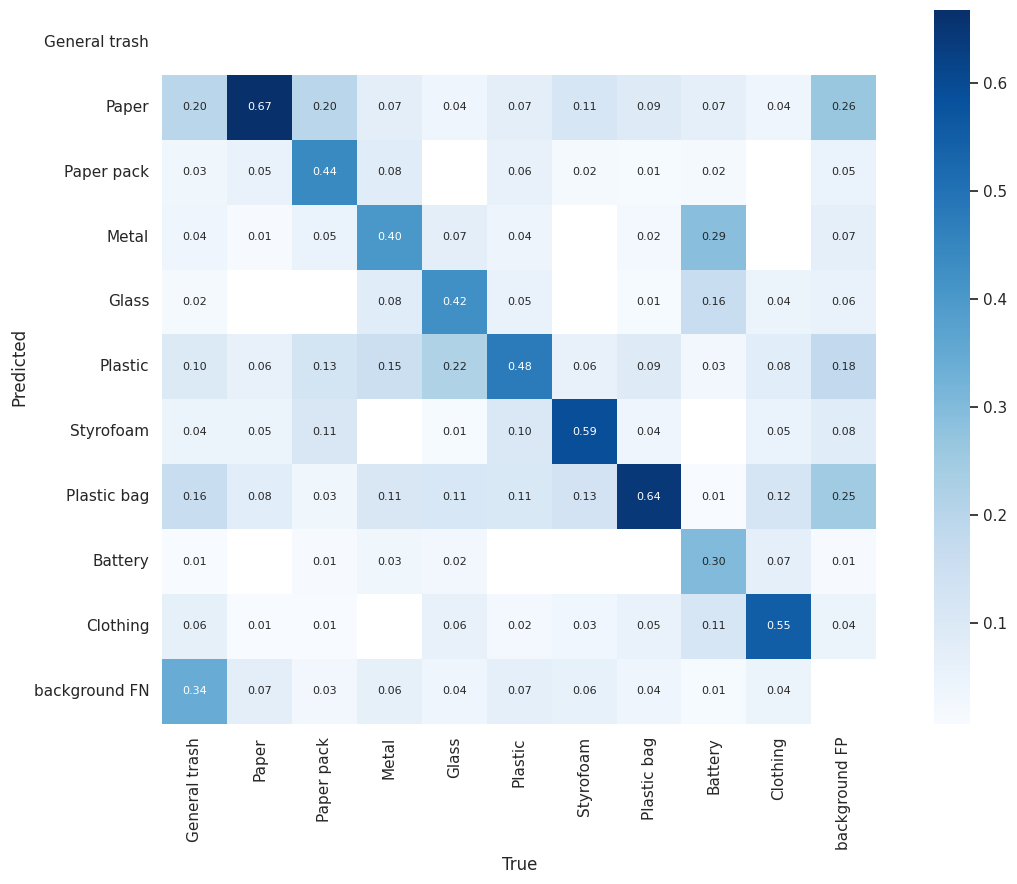

In [43]:
main('./dataset/train.json', './eff_train_predict_1024.csv', './cm1.png')

In [72]:
df = pd.read_csv('./eff_train_predict_1024.csv')

pred_class = []
for bstr in df['PredictionString']:
    # print(type(bstr))
    if isinstance(bstr, str):
        arr = bstr.split(' ')
        for idx in range(0, len(arr), 6):
            try:
                label_index = int(arr[idx])
                confidence_score = float(arr[idx+1])
                x_min = round(float(arr[idx+2]),1)
                x_max = round(float(arr[idx+3]),1)
                y_min = round(float(arr[idx+4]),1)
                y_max = round(float(arr[idx+5]),1)
                # print(label_index, confidence_score, x_min, x_max, y_min, y_max)
                pred_class.append(label_index)
            except Exception as e:
                # print(e)
                break
    # break

pdf = pd.DataFrame({'class': pred_class})
pdf.value_counts()

class
1        40585
7        37935
5        26710
6        12799
3         9640
4         8063
2         7817
9         6679
8         1426
dtype: int64

4883it [00:00, 5210.57it/s]


loading annotations into memory...
Done (t=0.08s)
creating index...
index created!
./cm0.png saved


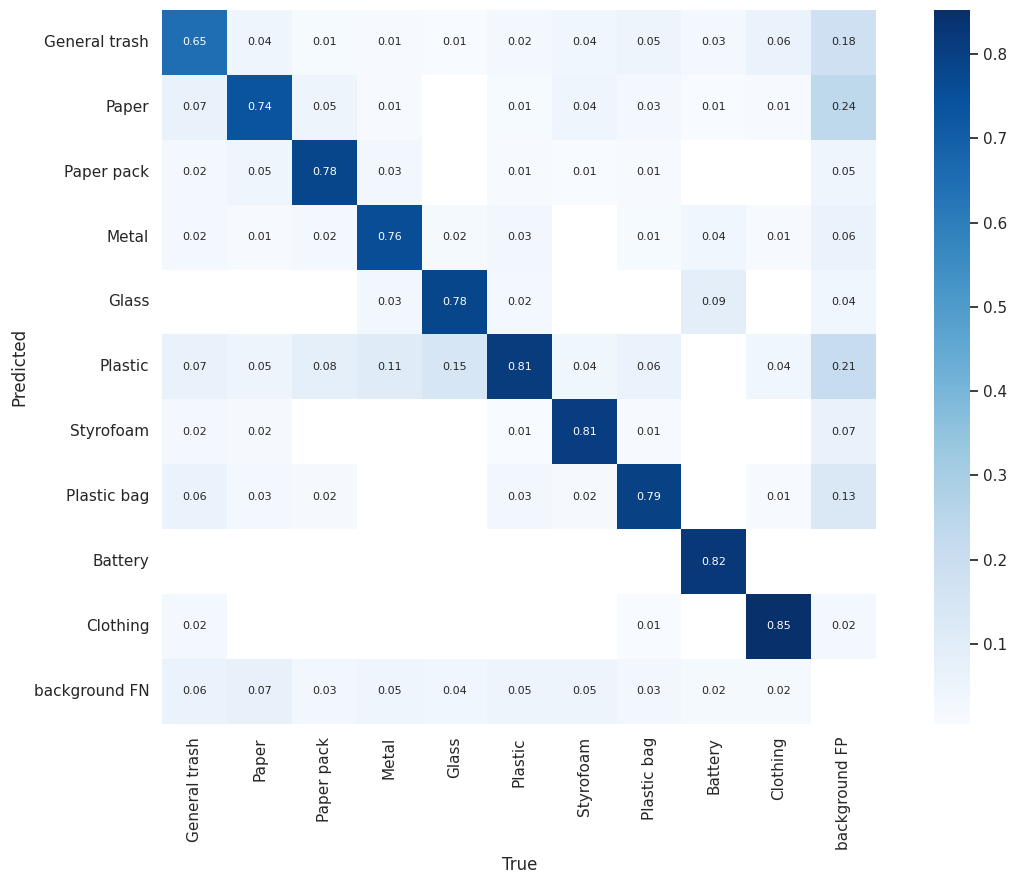

In [74]:
main('./dataset/train.json', './baseline/faster_rcnn/faster_rcnn_torchvision_predict_train.csv', './cm0.png')